In [1]:
!pip install prophet

In [2]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime
from prophet import Prophet


from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\akash\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# DATA

In [3]:
df=pd.read_csv("AMZN BP DATA.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
1,02-04-2014,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2,03-04-2014,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
3,04-04-2014,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
4,07-04-2014,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2204 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2204 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
2014-02-04,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2014-03-04,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
2014-04-04,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
2014-07-04,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


# Missing entries


In [11]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [12]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [13]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [14]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [15]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [16]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2204 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


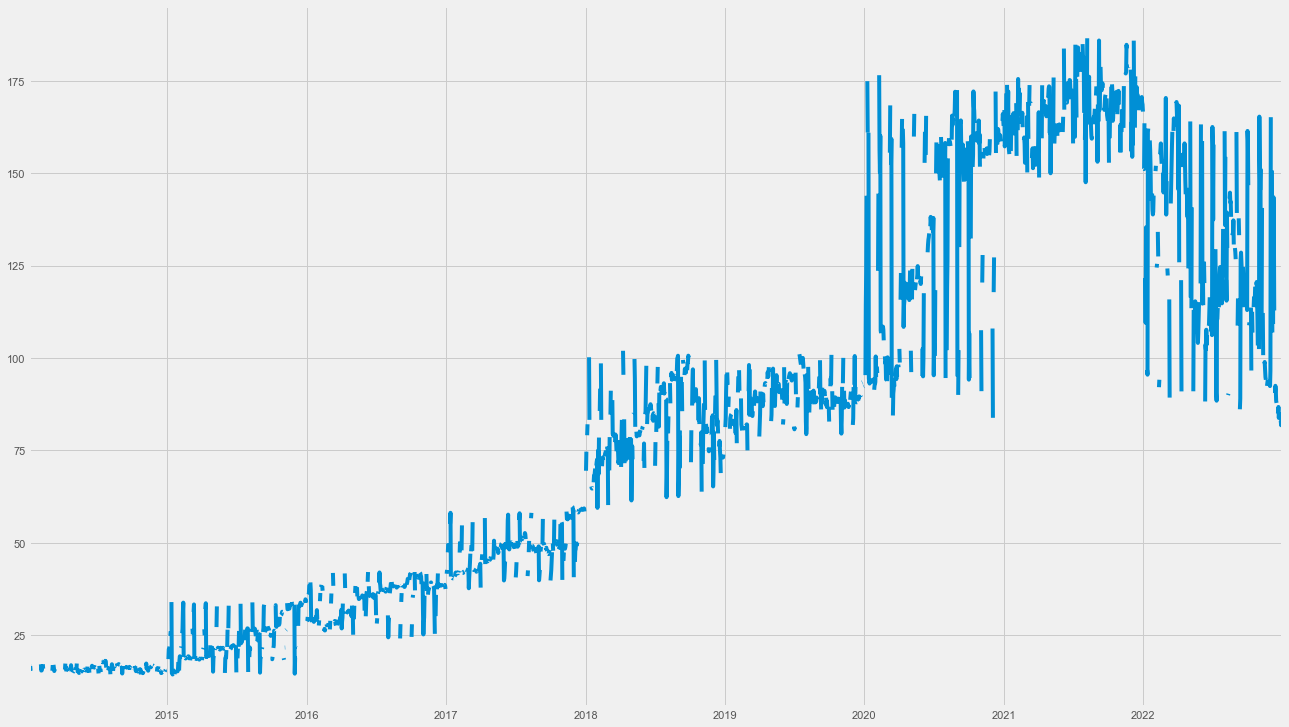

In [17]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [18]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ,ffilled
2014-01-04,16.904499,17.2215,16.900000,17.149500,72002000.0,3.0,NaN,3658.399902,17.149500
2014-01-05,15.206500,15.5240,15.200000,15.394500,86572000.0,5.0,0.188000,3594.360107,15.394500
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3594.360107,15.394500
2014-01-07,16.292999,16.6600,16.254999,16.619499,63472000.0,3.0,0.380499,3894.330078,16.619499
2014-01-08,15.684500,15.7915,15.229500,15.353000,148830000.0,6.0,-0.296500,3879.669922,15.353000
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3879.669922,15.353000
2014-01-10,16.101999,16.1085,15.777500,15.873000,61782000.0,4.0,-0.249000,3984.739990,15.873000
2014-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3984.739990,15.873000
2014-01-12,16.906000,17.0320,16.296499,16.299999,98898000.0,2.0,-0.632000,4287.810059,16.299999
2014-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4287.810059,16.299999


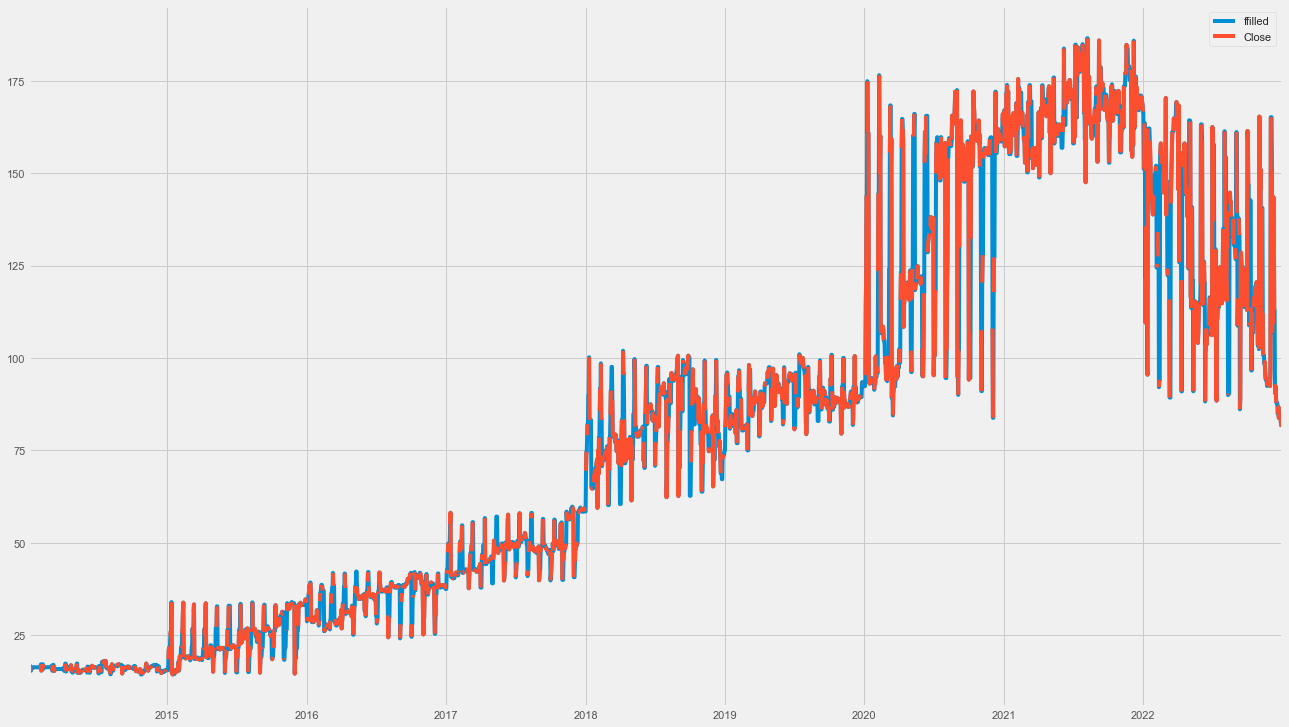

In [19]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [20]:
df.ffilled

2014-01-04    17.149500
2014-01-05    15.394500
2014-01-06    15.394500
2014-01-07    16.619499
2014-01-08    15.353000
                ...    
2022-12-26    85.250000
2022-12-27    83.040001
2022-12-28    81.820000
2022-12-29    84.180000
2022-12-30    84.000000
Name: ffilled, Length: 3283, dtype: float64

In [21]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,17.149500,17.149500,3658.399902,NaN
2014-01-05,15.394500,15.394500,3594.360107,0.188000
2014-01-06,15.394500,NaN,3594.360107,NaN
2014-01-07,16.619499,16.619499,3894.330078,0.380499
2014-01-08,15.353000,15.353000,3879.669922,-0.296500
...,...,...,...,...
2022-12-26,85.250000,NaN,10985.450200,NaN
2022-12-27,83.040001,83.040001,10822.509770,-2.209999
2022-12-28,81.820000,81.820000,10679.339840,-1.220001
2022-12-29,84.180000,84.180000,10951.049810,2.360000


In [22]:
df.drop(["Close"],axis=1,inplace=True)

In [23]:
df

,close,NASDAQ,Change
2014-01-04,17.149500,3658.399902,NaN
2014-01-05,15.394500,3594.360107,0.188000
2014-01-06,15.394500,3594.360107,NaN
2014-01-07,16.619499,3894.330078,0.380499
2014-01-08,15.353000,3879.669922,-0.296500
...,...,...,...
2022-12-26,85.250000,10985.450200,NaN
2022-12-27,83.040001,10822.509770,-2.209999
2022-12-28,81.820000,10679.339840,-1.220001
2022-12-29,84.180000,10951.049810,2.360000


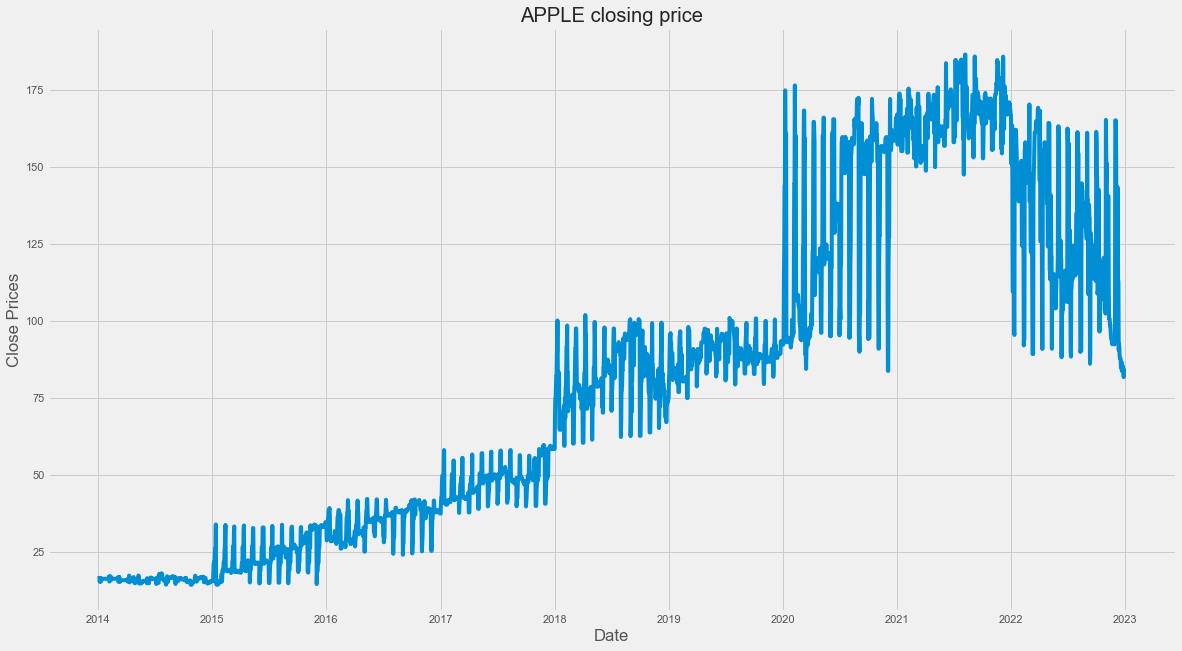

In [24]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# Time series features

In [25]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='close')
features_and_target = pd.concat([X, y], axis=1)

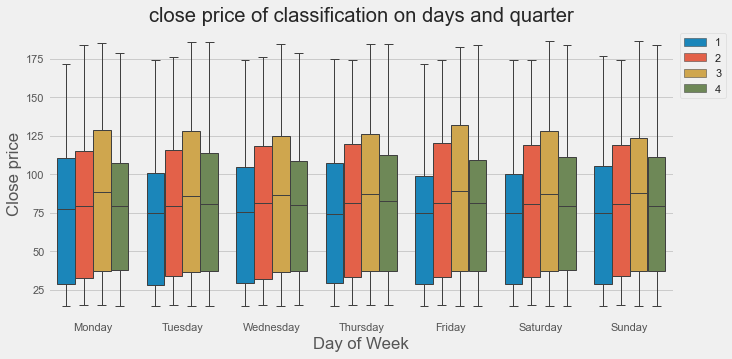

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='close',
            hue='quarter',
            ax=ax,
            linewidth=1)
ax.set_title('close price of classification on days and quarter')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Close price')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split


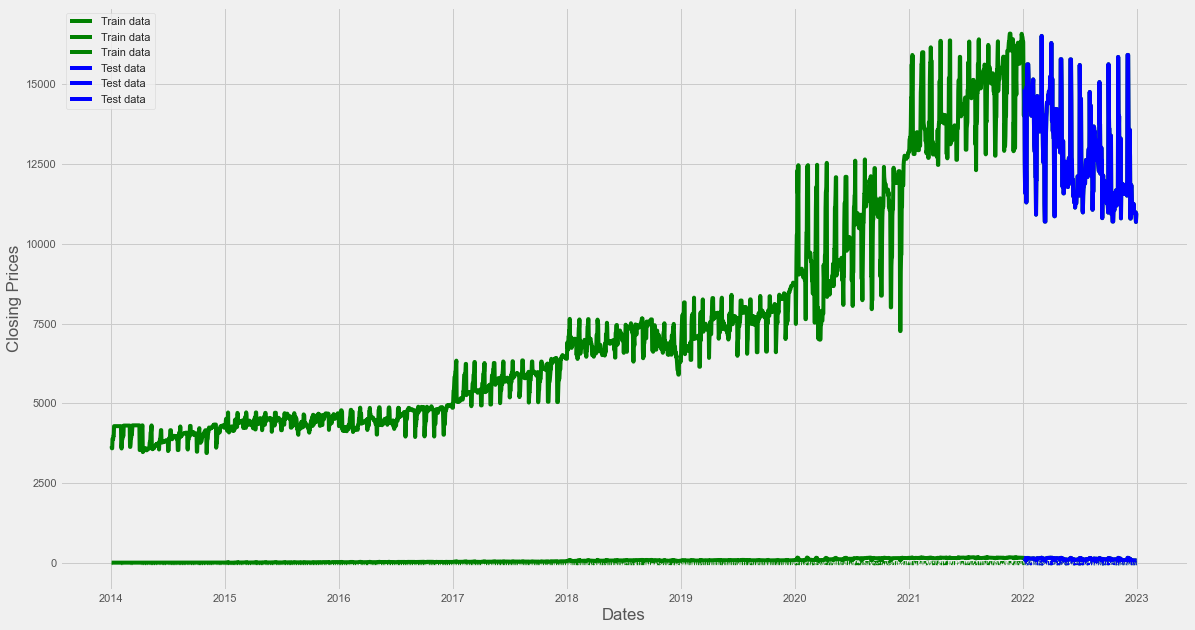

In [27]:
train = df.loc[df.index < '01-04-2022']
test = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

In [41]:
train.shape

(2922, 3)

In [42]:
test.shape

(361, 3)

# Simple Prophet Model


Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
Datetime column named: ds
target : y


In [43]:
# Format data for prophet model using ds and y
train_prophet =train.reset_index() \
    .rename(columns={'index':'ds',
                     'close':'y'})


In [44]:
train_prophet.head()

,ds,y,NASDAQ,Change
0,2014-01-04,17.149500,3658.399902,NaN
1,2014-01-05,15.394500,3594.360107,0.188000
2,2014-01-06,15.394500,3594.360107,NaN
3,2014-01-07,16.619499,3894.330078,0.380499
4,2014-01-08,15.353000,3879.669922,-0.296500


In [45]:
%%time
model = Prophet()
model.fit(train_prophet)


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\akash\AppData\Local\Temp\tmpqf7kazup\31juzmtp.json
DEBUG:cmdstanpy:input tempfile: C:\Users\akash\AppData\Local\Temp\tmpqf7kazup\cdvh0dal.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\akash\\anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=79304', 'data', 'file=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpqf7kazup\\31juzmtp.json', 'init=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpqf7kazup\\cdvh0dal.json', 'output', 'file=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpqf7kazup\\prophet_model_trwmty7\\prophet_model-20230924192326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

CPU times: total: 203 ms
Wall time: 1.3 s


In [46]:
# Predict on test set with model
test_prophet = test.reset_index() \
    .rename(columns={'index':'ds',
                     'close':'y'})

test_fcst = model.predict(test_prophet)

In [47]:
test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-04,182.102102,174.071179,199.114956,182.102102,182.102102,3.919387,3.919387,3.919387,0.117940,0.117940,0.117940,3.801448,3.801448,3.801448,0.0,0.0,0.0,186.021490
1,2022-01-05,182.184914,172.351119,198.369943,182.184914,182.184914,4.031083,4.031083,4.031083,-0.001853,-0.001853,-0.001853,4.032935,4.032935,4.032935,0.0,0.0,0.0,186.215997
2,2022-01-06,182.267726,173.926242,199.199195,182.267726,182.267726,4.210087,4.210087,4.210087,0.019390,0.019390,0.019390,4.190696,4.190696,4.190696,0.0,0.0,0.0,186.477813
3,2022-01-07,182.350538,173.901923,198.485363,182.350538,182.350538,4.186582,4.186582,4.186582,-0.089561,-0.089561,-0.089561,4.276143,4.276143,4.276143,0.0,0.0,0.0,186.537120
4,2022-01-08,182.433350,174.186737,199.625765,182.433350,182.433350,4.126765,4.126765,4.126765,-0.165409,-0.165409,-0.165409,4.292174,4.292174,4.292174,0.0,0.0,0.0,186.560115


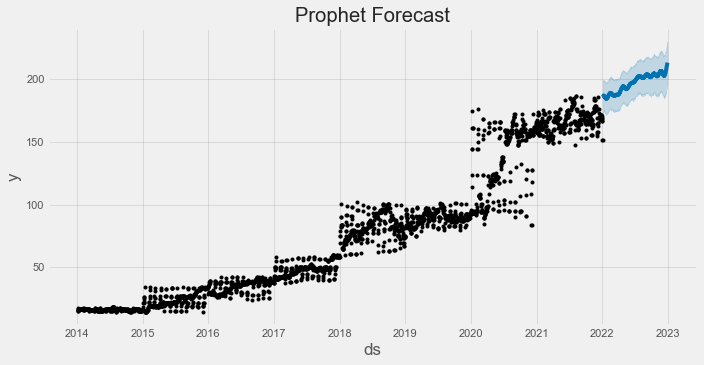

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()


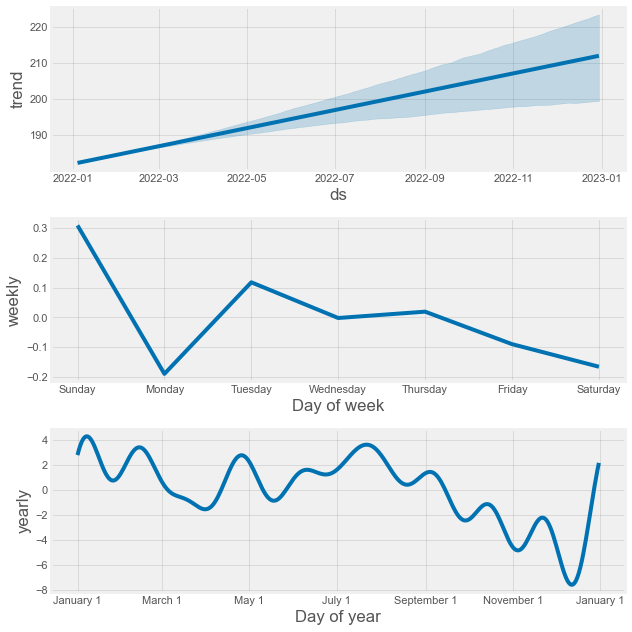

In [49]:
fig = model.plot_components(test_fcst)
plt.show()

# Compare Forecast to Actuals

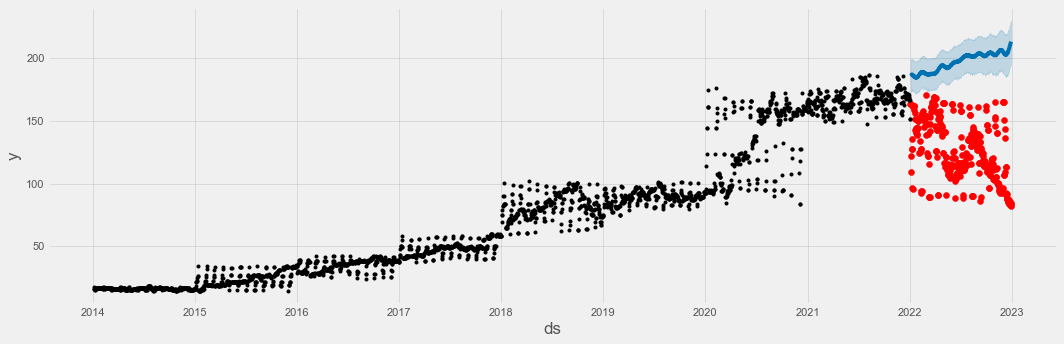

In [50]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [51]:
# plots

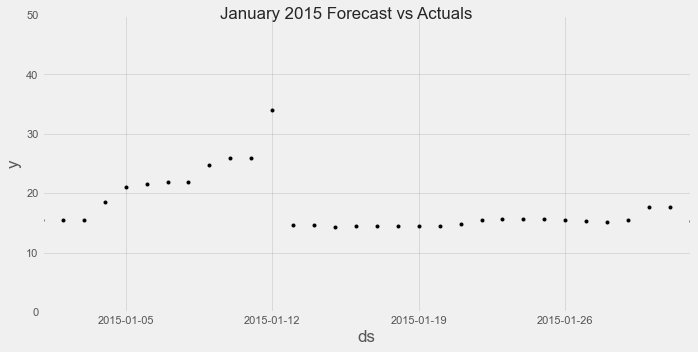

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_prophet.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Convert the date strings to datetime objects
lower_limit = pd.to_datetime('2015-01-01')
upper_limit = pd.to_datetime('2015-02-01')

ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

plt.show()



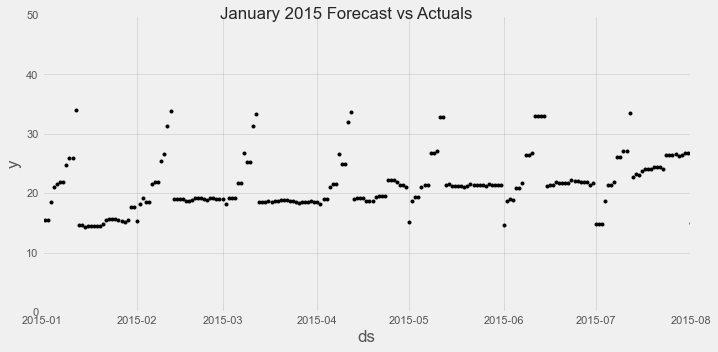

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_prophet.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Convert the date strings to datetime objects
lower_limit = pd.to_datetime('2015-01-01')
upper_limit = pd.to_datetime('2015-08-01')

ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

plt.show()

# Evaluate the model with Error Metrics


In [54]:
# report performance
mse = mean_squared_error(test_fcst['yhat'], test_prophet['y'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_fcst['yhat'], test_prophet['y'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_fcst['yhat'], test_prophet['y']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_prophet['y'] - test_fcst['yhat'])/np.abs(test_fcst['yhat']))
print('MAPE: '+str(mape))

MSE: 5819.417564465133
MAE: 70.90495558882657
RMSE: 76.28510709480018
MAPE: 0.3568464604811548
